In [ ]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/


Cloning into 'lag-llama'...
remote: Enumerating objects: 508, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 508 (delta 155), reused 114 (delta 114), pack-reused 325 (from 3)
Receiving objects: 100% (508/508), 286.89 KiB | 5.03 MiB/s, done.
Resolving deltas: 100% (253/253), done.


In [31]:
cd lag-llama

/Users/farhanmashrur/Desktop/cds/benchmark/foundation_model_notebooks/lag-llama


In [32]:
!pip install -r requirements.txt
!pip install -U torch torchvision
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir .



lag-llama.ckpt: 100%|██████████████████████| 29.5M/29.5M [00:00<00:00, 33.2MB/s]
Download complete. Moving file to lag-llama.ckpt
lag-llama.ckpt


In [51]:
from pathlib import Path

ckpt_path = Path( "lag-llama.ckpt") 
print(ckpt_path.exists())


True


In [52]:
!pip install -q torch torchvision torchaudio
!pip install -q gluonts pandas numpy matplotlib
!pip install -q einops transformers accelerate
!pip install -q lag-llama


In [ ]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from itertools import islice

# @title Enhanced Data Generation Functions

def generate_realistic_timeseries(n_points=365, series_type="sales", seed=42):
    """
    Generate realistic time series with various patterns and variability
    """
    np.random.seed(seed)
    
    if series_type == "sales":
        # Complex sales pattern with trend, seasonality, and shocks
        trend = np.linspace(100, 300, n_points)  # Growth trend
        
        # Multiple seasonal patterns
        weekly_pattern = 30 * np.sin(2 * np.pi * np.arange(n_points) / 7)  # Weekly
        monthly_pattern = 20 * np.sin(2 * np.pi * np.arange(n_points) / 30)  # Monthly
        yearly_pattern = 50 * np.sin(2 * np.pi * np.arange(n_points) / 365)  # Yearly
        
        # Add some random shocks and level changes
        shocks = np.zeros(n_points)
        shock_points = np.random.choice(n_points, size=int(n_points * 0.05), replace=False)
        shocks[shock_points] = np.random.normal(0, 50, len(shock_points))
        
        # Random walk component for more variability
        random_walk = np.cumsum(np.random.normal(0, 5, n_points))
        
        # High-frequency noise
        noise = np.random.normal(0, 15, n_points)
        
        # Combine all components
        values = trend + weekly_pattern + monthly_pattern + yearly_pattern + shocks + random_walk + noise
        
        # Ensure no negative values for sales
        values = np.maximum(values, 10)
        
    elif series_type == "stock":
        # Stock price with volatility clustering
        base_price = 100
        returns = np.random.normal(0.001, 0.02, n_points)  # Daily returns
        
        # Add volatility clustering
        volatility = np.ones(n_points) * 0.02
        for i in range(1, n_points):
            if abs(returns[i-1]) > 0.03:  # High volatility day
                volatility[i] = min(0.05, volatility[i-1] * 1.5)
            else:
                volatility[i] = max(0.01, volatility[i-1] * 0.95)
        
        returns = np.random.normal(0, volatility)
        
        # Convert to prices
        prices = [base_price]
        for ret in returns[1:]:
            prices.append(prices[-1] * (1 + ret))
        
        values = np.array(prices)
        
    elif series_type == "temperature":
        # Temperature with seasonal patterns and weather variations
        base_temp = 20
        yearly_cycle = 15 * np.sin(2 * np.pi * np.arange(n_points) / 365 - np.pi/2)
        daily_variation = 5 * np.sin(2 * np.pi * np.arange(n_points) / 1) + np.random.normal(0, 2, n_points)
        
        # Weather fronts (multi-day patterns)
        fronts = np.zeros(n_points)
        front_starts = np.random.choice(n_points-10, size=int(n_points/20), replace=False)
        for start in front_starts:
            duration = np.random.randint(3, 8)
            temp_change = np.random.normal(0, 8)
            fronts[start:start+duration] = temp_change * np.exp(-np.arange(duration)/3)
        
        values = base_temp + yearly_cycle + daily_variation + fronts
        
    elif series_type == "web_traffic":
        # Web traffic with weekly patterns and viral spikes
        base_traffic = 1000
        trend = np.linspace(0, 500, n_points)  # Growth
        
        # Strong weekly pattern (lower on weekends)
        weekly = np.tile([1.2, 1.1, 1.0, 1.0, 1.0, 0.7, 0.8], n_points//7 + 1)[:n_points]
        weekly_traffic = base_traffic * weekly
        
        # Viral spikes (rare but high impact)
        spikes = np.zeros(n_points)
        spike_days = np.random.choice(n_points, size=int(n_points * 0.02), replace=False)
        spike_magnitudes = np.random.exponential(2, len(spike_days))
        spikes[spike_days] = spike_magnitudes
        
        # Regular noise
        noise = np.random.normal(0, 100, n_points)
        
        values = weekly_traffic + trend + spikes * 1000 + noise
        values = np.maximum(values, 50)  # Minimum traffic
        
    else:  # generic
        # Generic highly variable series
        trend = np.cumsum(np.random.normal(0, 1, n_points))
        seasonality = 10 * np.sin(2 * np.pi * np.arange(n_points) / 12)
        noise = np.random.normal(0, 5, n_points)
        values = 100 + trend + seasonality + noise
    
    return values

def create_multi_series_dataset(n_series=5, n_points=365, start_date=None):
    """
    Create multiple realistic time series for testing
    """
    if start_date is None:
        start_date = datetime.now() - timedelta(days=n_points)
    
    dates = [start_date + timedelta(days=i) for i in range(n_points)]
    
    all_data = []
    series_types = ["sales", "stock", "temperature", "web_traffic", "generic"]
    
    for i in range(n_series):
        series_type = series_types[i % len(series_types)]
        values = generate_realistic_timeseries(n_points, series_type, seed=42+i)
        
        series_data = pd.DataFrame({
            'ds': dates,
            'value': values,
            'unique_id': f"{series_type}_{i}"
        })
        all_data.append(series_data)
    
    return pd.concat(all_data, ignore_index=True)


In [54]:
class LagLlama:
    """
    TimesFM-style interface for Lag-Llama forecasting model
    """
    def __init__(self, 
                 device="auto",
                 context_len=128,
                 horizon_len=30,
                 num_samples=100,
                 checkpoint_path="lag-llama.ckpt"):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device == "auto" else device
        self.context_len = context_len
        self.horizon_len = horizon_len
        self.num_samples = num_samples
        self.checkpoint_path = checkpoint_path
        self._predictor = None
        
        print(f"🦙 Initialized Lag-Llama with device: {self.device}")
        print(f"📊 Context: {self.context_len}, Horizon: {self.horizon_len}, Samples: {self.num_samples}")
    
    def _create_predictor(self):
        """Create and cache the predictor"""
        if self._predictor is not None:
            return self._predictor
            
        try:
            # Load checkpoint
            ckpt = torch.load(self.checkpoint_path, map_location=self.device, weights_only=False)
            estimator_args = ckpt.get("hyper_parameters", {}).get("model_kwargs", {})
            
            # RoPE scaling
            rope_scaling_arguments = {
                "type": "linear",
                "factor": max(1.0, (self.context_len + self.horizon_len) / 
                             estimator_args.get("context_length", 32)),
            }
            
            estimator = LagLlamaEstimator(
                ckpt_path=None,
                prediction_length=self.horizon_len,
                context_length=self.context_len,
                input_size=estimator_args.get("input_size", 1),
                n_layer=estimator_args.get("n_layer", 32),
                n_embd_per_head=estimator_args.get("n_embd_per_head", 32),
                n_head=estimator_args.get("n_head", 32),
                scaling=estimator_args.get("scaling", "mean"),
                time_feat=estimator_args.get("time_feat", True),
                rope_scaling=rope_scaling_arguments,
                batch_size=1,
                num_parallel_samples=self.num_samples,
                device=self.device,
            )
            
            lightning_module = estimator.create_lightning_module()
            lightning_module.load_state_dict(ckpt["state_dict"], strict=False)
            
            print("✅ Loaded checkpoint successfully")
            
        except Exception as e:
            print(f"⚠️  Checkpoint error: {e}")
            print("🔄 Using fallback...")
            
            estimator = LagLlamaEstimator(
                ckpt_path=None,
                prediction_length=self.horizon_len,
                context_length=self.context_len,
                rope_scaling={"type": "linear", "factor": 2.0},
                batch_size=1,
                num_parallel_samples=self.num_samples,
                device=self.device,
            )
            lightning_module = estimator.create_lightning_module()
        
        transformation = estimator.create_transformation()
        self._predictor = estimator.create_predictor(transformation, lightning_module)
        
        return self._predictor
    
    def forecast_on_df(self, inputs, freq="D", value_name="value", return_raw=False):
        """TimesFM-compatible forecasting interface"""
        
        # Prepare data
        df = inputs.copy()
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values(['unique_id', 'ds'] if 'unique_id' in df.columns else ['ds'])
        df[value_name] = pd.to_numeric(df[value_name], errors='coerce').astype('float32')
        
        if 'unique_id' not in df.columns:
            df['unique_id'] = 'series_0'
        
        # Create GluonTS dataset
        dataset = PandasDataset.from_long_dataframe(
            df, target=value_name, item_id="unique_id", timestamp="ds", freq=freq
        )
        
        # Get predictor and forecast
        predictor = self._create_predictor()
        
        print("🔮 Generating forecasts...")
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=dataset,
            predictor=predictor,
            num_samples=self.num_samples
        )
        
        forecasts = list(forecast_it)
        tss = list(ts_it)
        
        if return_raw:
            return forecasts, tss
        
        # Convert to DataFrame
        forecast_results = []
        for i, forecast in enumerate(forecasts):
            unique_id = getattr(forecast, 'item_id', f"series_{i}")
            
            try:
                last_date = forecast.start_date.to_timestamp()
            except:
                last_date = pd.Timestamp.now()
            
            future_dates = pd.date_range(start=last_date, periods=self.horizon_len, freq=freq)
            
            mean_forecast = forecast.mean
            q10 = forecast.quantile(0.1)
            q50 = forecast.quantile(0.5)
            q90 = forecast.quantile(0.9)
            
            for j, date in enumerate(future_dates):
                forecast_results.append({
                    'unique_id': unique_id,
                    'ds': date,
                    f'{value_name}': mean_forecast[j],
                    f'{value_name}_median': q50[j],
                    f'{value_name}_q10': q10[j],
                    f'{value_name}_q90': q90[j]
                })
        
        return pd.DataFrame(forecast_results)


In [57]:
def plot_forecasts_official_style(forecasts, tss, prediction_length, num_series=9):
    """
    Official Lag-Llama plotting style - exactly like the original notebook
    """
    plt.figure(figsize=(20, 15))
    date_formater = mdates.DateFormatter('%b, %d')
    plt.rcParams.update({'font.size': 15})
    
    # Iterate through the first num_series series
    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), num_series):
        ax = plt.subplot(3, 3, idx+1)
        
        # Plot historical data (last 4 * prediction_length points)
        historical_data = ts[-4 * prediction_length:].to_timestamp()
        plt.plot(historical_data, label="target", color='blue', linewidth=2)
        
        # Plot forecast with confidence intervals (official green style)
        forecast.plot(color='g', show_label=True)
        
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formater)
        ax.set_title(f"Series: {forecast.item_id}")
        ax.grid(True, alpha=0.3)
        
        # Add legend only to first subplot
        if idx == 0:
            ax.legend(['Historical', 'Forecast', '80% Confidence'], loc='upper left')
    
    plt.gcf().tight_layout()
    plt.show()

def plot_single_series_detailed(forecasts, tss, series_idx=0):
    """
    Detailed plot for a single series with better styling
    """
    forecast = forecasts[series_idx]
    ts = tss[series_idx]
    
    plt.figure(figsize=(15, 8))
    
    # Historical data (more points for context)
    hist_points = min(len(ts), 120)  # Show last 120 points
    historical_data = ts[-hist_points:].to_timestamp()
    
    plt.plot(historical_data, label="Historical Data", color='#1f77b4', linewidth=2.5, alpha=0.8)
    
    # Forecast - fix the freq issue
    forecast_dates = pd.date_range(
        start=forecast.start_date.to_timestamp(),
        periods=len(forecast.mean),
        freq='D'  # Fixed: use 'D' instead of ts.freq
    )
    
    plt.plot(forecast_dates, forecast.mean, 
             label="Forecast (Mean)", color='#d62728', linewidth=2.5, linestyle='--')
    
    # Confidence intervals
    plt.fill_between(forecast_dates, 
                     forecast.quantile(0.1), 
                     forecast.quantile(0.9),
                     alpha=0.3, color='#d62728', label='80% Confidence Interval')
    
    plt.fill_between(forecast_dates, 
                     forecast.quantile(0.25), 
                     forecast.quantile(0.75),
                     alpha=0.5, color='#d62728', label='50% Confidence Interval')
    
    # Styling
    plt.title(f'Detailed Forecast: {forecast.item_id}', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, hist_points//10)))
    
    plt.tight_layout()
    plt.show()

📊 Creating realistic time series dataset...
📈 Sample data:

sales_0:
  Range: 96.5 - 524.3
  Mean: 336.5, Std: 107.2

stock_1:
  Range: 62.6 - 114.4
  Mean: 86.4, Std: 13.7

temperature_2:
  Range: -7.0 - 40.5
  Mean: 20.7, Std: 11.4


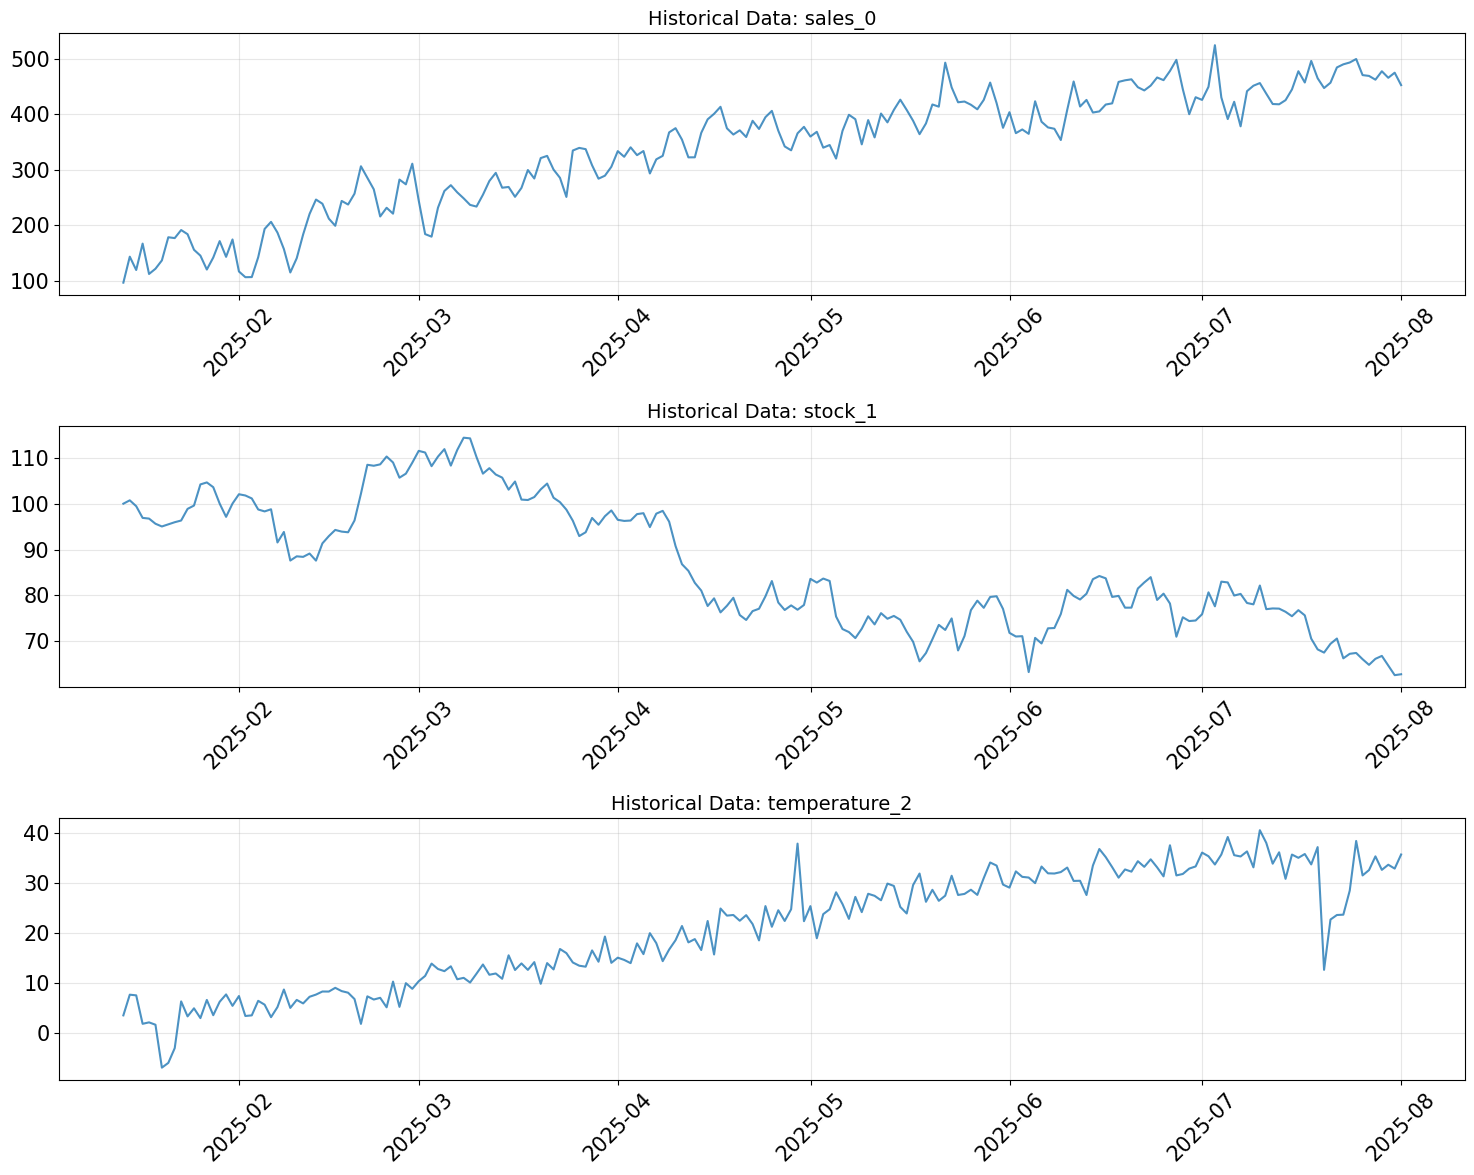

🦙 Initialized Lag-Llama with device: cpu
📊 Context: 64, Horizon: 20, Samples: 100

🔮 Generating forecasts...
✅ Loaded checkpoint successfully
🔮 Generating forecasts...
⏱️  Forecast time: 13.82s

📊 Official Lag-Llama Style Plot:


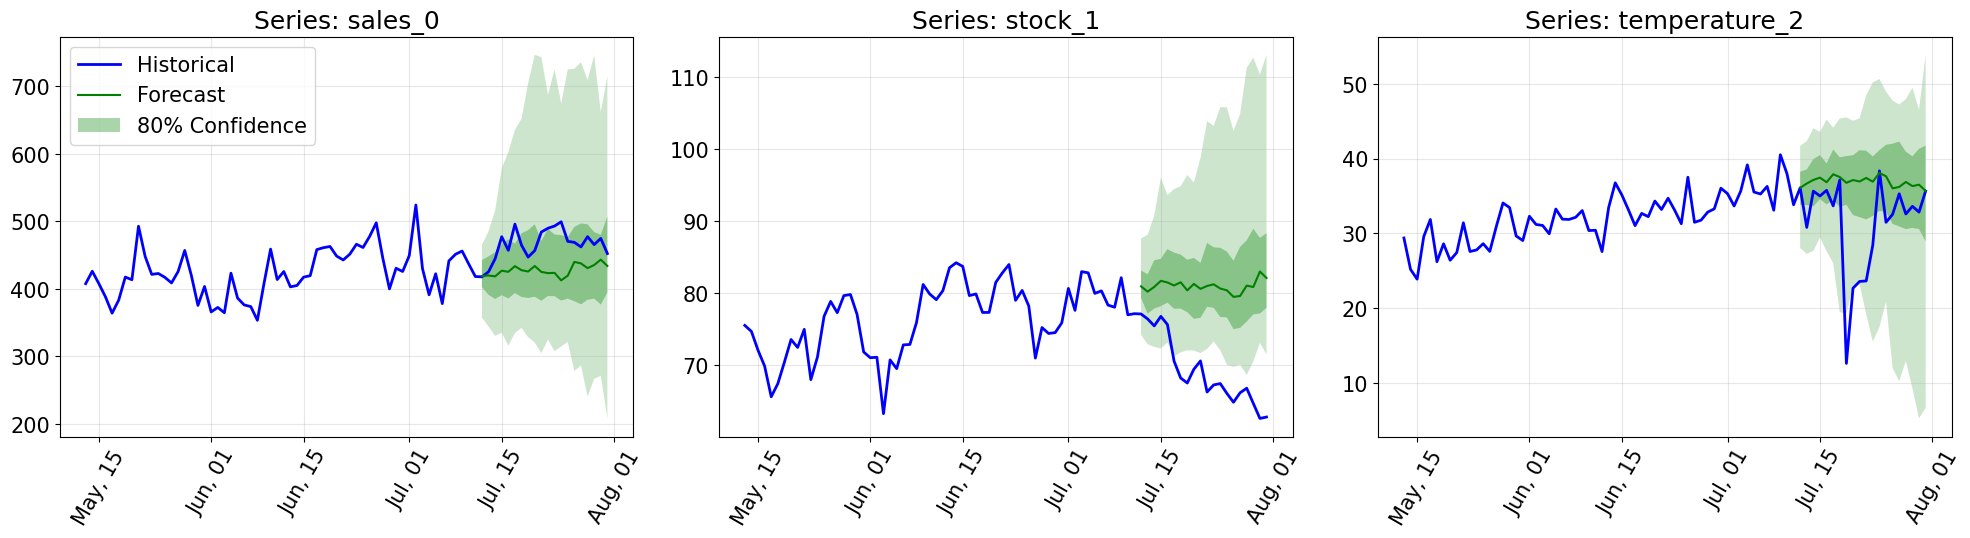


📈 Detailed Single Series Plot:


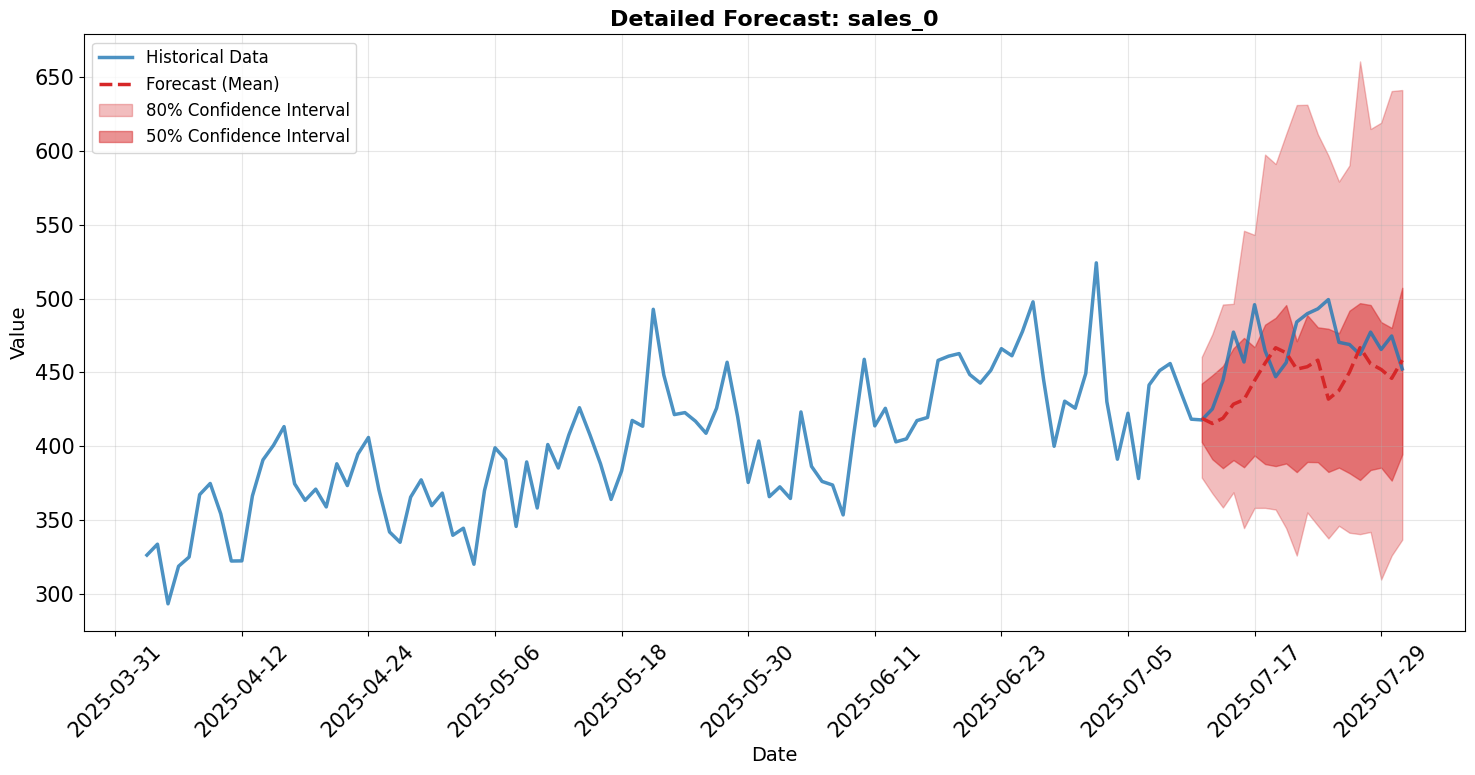

🔮 Generating forecasts...

📋 Forecast DataFrame:
  unique_id         ds       value  value_median   value_q10   value_q90
0   sales_0 2025-07-12  421.120575    424.765900  386.576294  459.797607
1   sales_0 2025-07-13  424.930573    425.557037  379.395477  489.432922
2   sales_0 2025-07-14  415.363251    426.230804  370.438141  485.716339
3   sales_0 2025-07-15  424.543274    427.307129  359.259003  511.092834
4   sales_0 2025-07-16  434.836517    437.133606  385.677246  543.308228
5   sales_0 2025-07-17  447.263916    441.426453  376.859741  526.542175
6   sales_0 2025-07-18  447.290771    439.529816  363.587280  561.718262
7   sales_0 2025-07-19  443.693176    435.164673  347.826752  550.042542
8   sales_0 2025-07-20  440.302124    436.503540  348.395996  558.330627
9   sales_0 2025-07-21  450.369507    429.455750  360.001343  572.437317
Shape: (60, 6)


In [58]:
# Create realistic dataset
print("📊 Creating realistic time series dataset...")
data = create_multi_series_dataset(n_series=3, n_points=200)

# Show some sample data
print("📈 Sample data:")
for series_id in data['unique_id'].unique():
    series_data = data[data['unique_id'] == series_id]
    print(f"\n{series_id}:")
    print(f"  Range: {series_data['value'].min():.1f} - {series_data['value'].max():.1f}")
    print(f"  Mean: {series_data['value'].mean():.1f}, Std: {series_data['value'].std():.1f}")

# Plot the raw data to show variability
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for i, series_id in enumerate(data['unique_id'].unique()):
    series_data = data[data['unique_id'] == series_id]
    axes[i].plot(series_data['ds'], series_data['value'], linewidth=1.5, alpha=0.8)
    axes[i].set_title(f'Historical Data: {series_id}', fontsize=14)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Initialize Lag-Llama
llama = LagLlama(
    device="auto",
    context_len=64,
    horizon_len=20,
    num_samples=100
)

# Generate forecasts
print("\n🔮 Generating forecasts...")
import time
start_time = time.time()

# Get raw forecasts for official plotting
forecasts_raw, tss_raw = llama.forecast_on_df(
    inputs=data,
    freq="D",
    value_name="value",
    return_raw=True
)

print(f"⏱️  Forecast time: {time.time() - start_time:.2f}s")

# Official Lag-Llama style plot
print("\n📊 Official Lag-Llama Style Plot:")
plot_forecasts_official_style(forecasts_raw, tss_raw, prediction_length=20, num_series=3)

# Detailed single series plot
print("\n📈 Detailed Single Series Plot:")
plot_single_series_detailed(forecasts_raw, tss_raw, series_idx=0)

# Also get DataFrame format for compatibility
forecast_df = llama.forecast_on_df(
    inputs=data,
    freq="D", 
    value_name="value"
)

print("\n📋 Forecast DataFrame:")
print(forecast_df.head(10))
print(f"Shape: {forecast_df.shape}")
